In [2]:
import networkx as nx
import numpy as np
from src.metaqaoa import gene_qaoa_ansatz, gene_random_instance, gene_qaoa_layers, gene_ham, MetaQAOA
import mindspore as ms
from mindspore import Tensor, nn, ops
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")

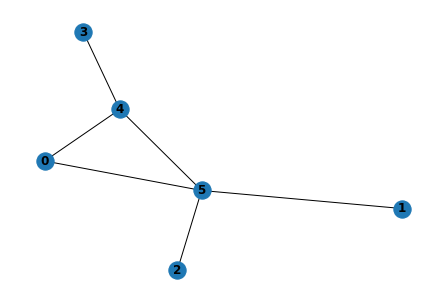

In [3]:
P = 10
g = gene_random_instance(6)
nx.draw(g, with_labels=True, font_weight='bold')

In [7]:
QNN = gene_qaoa_layers(g, P)
# opti = nn.Adam(QNN.trainable_params(), learning_rate=0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
# train_net = nn.TrainOneStepCell(QNN, opti)
# for i in range(20):
#     cut = (len(g.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
#     # if i%10 == 0:
#     print("train step:", i, ", cut:", cut)
QNN.trainable_params()

[]

In [5]:
cuts = []
for i in g.nodes:
    # print('one size:', [i], 'cut=', nx.cut_size(g, [i]))           # 一组1个节点、另一组4个节点的所有情况
    cuts.append(nx.cut_size(g, [i]))
    for j in range(i):
        # print('one size:', [i, j], 'cut=', nx.cut_size(g, [i, j]))  # 一组2个节点、另一组3个节点的所有情况
        cuts.append(nx.cut_size(g, [i, j]))

        for k in range(j):
            # print('one size:', [i, j, k], 'cut=', nx.cut_size(g, [i, j, k]))  # 一组2个节点、另一组3个节点的所有情况
            cuts.append(nx.cut_size(g, [i, j, k]))
print(max(cuts))


5


In [6]:
metaqaoa = MetaQAOA(5)
print(metaqaoa)
metaqaoa.trainable_params()

MetaQAOA<
  (lstm): LSTM<
    (rnn): _DynamicLSTMCPUGPU<>
    (reverse): _Reverse<>
    (reverse_sequence): _ReverseSequence<>
    (dropout_op): Dropout<keep_prob=1.0>
    >
  >


[Parameter (name=lstm.weight_ih_l0, shape=(4, 1), dtype=Float32, requires_grad=True),
 Parameter (name=lstm.weight_hh_l0, shape=(4, 1), dtype=Float32, requires_grad=True),
 Parameter (name=lstm.bias_ih_l0, shape=(4,), dtype=Float32, requires_grad=True),
 Parameter (name=lstm.bias_hh_l0, shape=(4,), dtype=Float32, requires_grad=True)]

In [7]:
theta = Tensor(np.ones([1, 2*P, 1]).astype(np.float32))
h = Tensor(np.zeros([1, 1, 1]).astype(np.float32))
y = Tensor(np.zeros([1, 1, 1]).astype(np.float32))

theta_list, y_list = metaqaoa(theta, h, y, QNN)

In [8]:
[t.shape for t in theta_list]

[(1, 20, 1), (1, 20, 1), (1, 20, 1), (1, 20, 1), (1, 20, 1)]

In [9]:
y_list

[Tensor(shape=[], dtype=Float32, value= 0),
 Tensor(shape=[], dtype=Float32, value= 0.294539),
 Tensor(shape=[], dtype=Float32, value= 0.041171),
 Tensor(shape=[], dtype=Float32, value= -0.281689),
 Tensor(shape=[], dtype=Float32, value= 0.252002),
 Tensor(shape=[], dtype=Float32, value= -0.160262)]

In [12]:
a = Tensor(np.array([1]))
b = Tensor(np.array([-1]))
minx = a
t = [minx]
if a > b:
    minx = b
t

[Tensor(shape=[1], dtype=Int64, value= [1])]

In [1]:
metaqaoa.trainable_params()

NameError: name 'metaqaoa' is not defined

In [9]:
import numpy as np
import mindspore as ms
from mindquantum.core.circuit import Circuit
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQEncoderOnlyOps
from mindquantum.simulator import Simulator
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
circ = Circuit().ry('a', 0).h(0).rx('b', 0).as_encoder()
ham = Hamiltonian(QubitOperator('Z0'))
sim = Simulator('projectq', 1)
grad_ops = sim.get_expectation_with_grad(ham, circ)
data = np.array([[0.1, 0.2], [0.3, 0.4]])
f, g = grad_ops(data)
f, g


# net = MQEncoderOnlyOps(grad_ops)
# f_ms = net(ms.Tensor(data))
# f_ms





(array([[0.0978434 +0.j],
        [0.27219214+0.j]]),
 array([[[ 0.97517033+0.j, -0.01983384+0.j]],
 
        [[ 0.87992318+0.j, -0.11508099+0.j]]]))